## Revisiting Gaussian Process Regression of the Mauna Loa Dataset using Automated Kernel Engineering

<!-- div style="text-align:center">
<img src="../images/daniel-norris-oVX8AmhiOCY-unsplash.jpg" width="800px"/>
<br>
"Photo by <a href='https://unsplash.com/@danielnorris?utm_content=creditCopyText&utm_medium=referral&utm_source=unsplash'>Daniel Norris</a> on <a href='https://unsplash.com/photos/a-dark-sky-with-red-clouds-in-it-oVX8AmhiOCY?utm_content=creditCopyText&utm_medium=referral&utm_source=unsplash'>Unsplash</a>"  
</div-->

### [Alessio Tamburro](https://alessiot.github.io/dsprojects/)
<br>

**The source code for this article is available [here](https://github.com/alessiot/polygp-sklearn)**
<br>

**Data and more info on the subject [here](https://gml.noaa.gov/ccgg/trends/)**
<br>

*Note: the html version of this notebook was created with [nbconvert](https://nbconvert.readthedocs.io/en/latest/config_options.html) and running the command jupyter nbconvert --to html --TagRemovePreprocessor.remove_input_tags="notvisible" notebook.ipynb. A tag "notvisible" was added to the cells that are not displayed in this rendered html*
<br>


In this study, we want to forecast the monthly average atmospheric $CO_2$ concentrations (in parts per million by volume (ppm)) collected at the Mauna Loa Observatory in Hawaii. The dataset used for this study spans the period between 1958 and 2001. 
The goal is to train a model of the $CO_2$ concentration as a function of the time for the data collected until 2001 and extracpolate for the following years until today. A similar study is available from the book of [Carl E. Rasmussen and Christopher K.I. Williams, “Gaussian Processes for Machine Learning”, MIT Press 2006](https://www.gaussianprocess.org/gpml/chapters/RW.pdf) and has been [demonstrated](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html) using the Python library of *scikit-learn* for Gaussian Process regression [gaussian_process](https://github.com/scikit-learn/scikit-learn/tree/3f89022fa04d293152f1d32fbc2a5bdaaf2df364/sklearn/gaussian_process).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import plotly.io as pio
pio.renderers.default = "notebook"

In [3]:
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.datasets import fetch_openml

import pandas as pd
import numpy as np

import datetime

import matplotlib.pyplot as plt
import plotly.graph_objects as go

try:
    import polygp
    from polygp import train_gp, _calculate_bic, _calculate_num_params, build_poly_kernel
except ImportError as e:
    # this is needed if you decide not to install polygp 
    import sys
    sys.path.append('../')    
    from polygp.src.polygp import train_gp, _calculate_bic, _calculate_num_params, build_poly_kernel

import itertools

In [4]:
def create_regression_plot(plot_title, text_display, dic_traces):

    """
    This function returns a Plotly figure with multiple lines.  
    The input is a dictionary whose keys are the traces, the values are dictionaries containing the data for the traces. 'X' are the x-axis values (2d array), 'Z' are the y-axis values (2d array), 'dX' and 'dZ' are the errors of 'X' and 'Z' respectively, 'label' is the trace label to display in the legend, 'ix' and 'iz' are the indexes of the columns of 'X', 'Z', 'dX', 'dZ' we want to show the data for

    mode: lines+markers or lines or markers
    """


    fig = go.Figure()

    min_x = 1e32
    max_x = -1e32
    min_y = 1e32
    max_y = -1e32
    for trace_name, trace_data in dic_traces.items():
        #print(trace_name, trace_data)
        x_data = trace_data['X']
        z_data = trace_data['Z']
        dx_data = trace_data['dX']
        dz_data = trace_data['dZ']
        label = trace_data['label']
        xlabel = trace_data['xlabel']
        ylabel = trace_data['ylabel']
        ix = trace_data['ix']
        iz = trace_data['iz']
        modes = trace_data['modes']
        errors = trace_data['errors']

        show_xbars = (dx_data is not None) & ('bars' in errors)
        show_zbars = (dz_data is not None) & ('bars' in errors)
        show_confidence = ('lines' in modes) and ('confidence' in errors) and (dz_data is not None)

        min_x = min([np.min(x_data), min_x])
        max_x = max([np.max(x_data), max_x])
        min_y = min([np.min(z_data), min_y])
        max_y = max([np.max(z_data), max_y])

        # Make sure values are sorted before plotting
        sorted_indices = np.argsort(x_data[:,ix])

        # display data as lines, points or both
        # display error bars if requested
        fig.add_trace(go.Scatter(
            x=x_data[sorted_indices, ix],
            y=z_data[sorted_indices, iz],
            error_x=dict(array=dx_data[sorted_indices, ix], visible=True) if show_xbars else None,
            error_y=dict(array=dz_data[sorted_indices, iz], visible=True) if show_zbars else None,
            mode=modes,
            line=trace_data['line_dict'],
            name=label
        ))

        # Display errors as conf. intervals
        if show_confidence:
            # Create confidence interval shading
            upper_bound = z_data[sorted_indices,iz] + 1.96 * dz_data[sorted_indices,iz]
            lower_bound = z_data[sorted_indices,iz] - 1.96 * dz_data[sorted_indices,iz]

            min_y = min([min_y, np.min(lower_bound)])
            max_y = max([max_y, np.max(upper_bound)])

            fig.add_trace(go.Scatter(
                name="95% C.I. Lower Bound",
                x=x_data[sorted_indices,ix],
                y=lower_bound,
                line=trace_data['line_dict'],
                #line=dict(width=1, shape='spline'),
            ))
            fig.add_trace(go.Scatter(
                name="95% C.I. Upper Bound",
                x=x_data[sorted_indices,ix],
                y=upper_bound,
                fill="tonexty",
                fillcolor='rgba(0, 128, 0, 0.2)', # to generalize...
                line=trace_data['line_dict'],
                #line=dict(width=1, shape='spline'),
            ))

    fig.update_layout(
        title=plot_title,
        xaxis=dict(title=xlabel),
        yaxis=dict(title=ylabel),
        legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1),
        showlegend=True,
        #template='plotly_dark', 
        plot_bgcolor='white', 
        paper_bgcolor='white',
        xaxis_range = [min_x, max_x],   
        yaxis_range = [min_y, max_y],
        annotations=[
            dict(
                x=min_x + 0.1*(max_x-min_x),
                y=max_y - 0.1*(max_y-min_y),
                align='right',
                xref="x",
                yref="y",
                text=text_display,
                showarrow=False,
                font=dict(size=15),
                ax=0,
                ay=-40,
            )
        ]
    )

    return fig


### Previous Study

We will start by reproducing the exercise of Rasmussen and Williams following the *scikit-learn* notebook code mentioned earlier. The data is publicly available through the [OpenML](https://www.openml.org/) project.

In [5]:
co2 = fetch_openml(data_id=41187, as_frame=True, parser="pandas")
display(co2.frame.head())

year  month  day  weight  flag station    co2
0  1958      3   29       4     0     MLO  316.1
1  1958      4    5       6     0     MLO  317.3
2  1958      4   12       4     0     MLO  317.6
3  1958      4   19       6     0     MLO  317.5
4  1958      4   26       2     0     MLO  316.4

In [6]:
co2_data = co2.frame
co2_data["date"] = pd.to_datetime(co2_data[["year", "month", "day"]])
co2_data = co2_data[["date", "co2"]].set_index("date")

display(co2_data.head())

co2
date             
1958-03-29  316.1
1958-04-05  317.3
1958-04-12  317.6
1958-04-19  317.5
1958-04-26  316.4

We take the monthly average and drop the months for which no measurements were collected. 

In [7]:
co2_data = co2_data.resample("M").mean().dropna(axis="index", how="any")

In [8]:
# convert dattime into fractional year
X = (co2_data.index.year + co2_data.index.month / 12).to_numpy()
y = co2_data["co2"].to_numpy()

co2_data = pd.DataFrame({'date': X, 'co2': y})
display(co2_data.head())

date         co2
0  1958.250000  316.100000
1  1958.333333  317.200000
2  1958.416667  317.433333
3  1958.583333  315.625000
4  1958.666667  314.950000

In [9]:
hist_plot = create_regression_plot(plot_title='Monthly average of measurements\nfrom Mauna Loa Observatory',
                                   text_display='',
                                   dic_traces={'trace1': {'X': co2_data[['date']].values, 
                                                'Z': co2_data[['co2']].values, 
                                                'dX': None, 'dZ': None, 
                                                'label': 'CO2 - Historical', 
                                                'xlabel': 'date',
                                                'ylabel': 'CO2',
                                                'modes':'lines+markers', 
                                                'errors': 'confidence+bars',
                                                'line_dict': dict(dash='dash', color='rgba(0, 0, 255, 1)'), 'ix': 0, 'iz': 0}})
#                                    Z_true_preds=mean_prediction, Z_std_preds=std_prediction, 
#                                    text_display=f"llh: {np.round(gaussian_process_ras.log_marginal_likelihood_value_,3)}; mse: {np.round(mse_all,3)}; r2: {np.round(r2_all,3)}"

In [10]:
# display training data
hist_plot

Looking at the data, we can make some assumptions regarding the function describing the measurements. We can observe a long term rising trend, a seasonal variation and smaller irregularities. 
These assumptions will help us to engineer manually the kernel to use for fitting a Gaussian process regression model.

In [11]:
long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)

seasonal_kernel = (
    2.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)

irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)

noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
)

co2_kernel = (
    long_term_trend_kernel + seasonal_kernel + irregularities_kernel + noise_kernel
)

In [12]:
gaussian_process_ras = GaussianProcessRegressor(kernel=co2_kernel, normalize_y=False)
gaussian_process_ras.fit(co2_data[['date']].values, co2_data['co2'] - co2_data['co2'].mean())

llh = gaussian_process_ras.log_marginal_likelihood_value_
krnl_num_params = _calculate_num_params(co2_kernel)
bic = _calculate_bic(len(co2_data), llh, krnl_num_params)

After we fit the model using the given kernel, the composed kernel parameter values are also optimized by maximizing the log marginal likelihood 

$\log p(y|X) = -\frac{1}{2}(y - m(X))^T(K+\sigma^2_n I)^{-1}(y - m(X)) - \frac{1}{2}\log|K+\sigma^2_n I|-\frac{n}{2}\log2\pi$,

where $m: \mathbb{R}^d \rightarrow \mathbb{R}$ is the mean function of a Gaussian process and the notation $m(X)$
represents a vector function obtained by applying the mean function to each of the $n$ points in $y$; $y$ is the target, $K$ is the prior covariance (more on this a little later in this notebook), $\sigma^2_n$ is the noise variance, $\log|\dot|$ indicates the logarithm of the determinant. More on this topic can be reviewed in the book of [Carl E. Rasmussen and Christopher K.I. Williams, “Gaussian Processes for Machine Learning”, MIT Press 2006](https://www.gaussianprocess.org/gpml/chapters/RW.pdf) (eq. 2.30).

The optimized kernel components are the following:

In [13]:
str(gaussian_process_ras.kernel_).split(' + ')

['44.8**2 * RBF(length_scale=51.6)',
 '2.64**2 * RBF(length_scale=91.5) * ExpSineSquared(length_scale=1.48, periodicity=1)',
 '0.536**2 * RationalQuadratic(alpha=2.89, length_scale=0.968)',
 '0.188**2 * RBF(length_scale=0.122)',
 'WhiteKernel(noise_level=0.0367)']

We can interpret this kernel as follows: 
* a long-term rising trend with an amplitude of ~45 ppm and a length-scale of ~52 years is the dominant component;
* an additional periodic component has an amplitude of ~2.6ppm, a decay time of ~90 years and a length-scale of ~1.5. The decay time magnitude (much greater than the periodicity) is an indication that this component follows closely the seasonal periodicity;
* the noise has an amplitude of ~0.2 ppm with a length scale of ~0.12 years and a white-noise contribution of ~0.04 ppm.

In [14]:
mean_prediction, std_prediction = gaussian_process_ras.predict(co2_data[['date']].values, return_std=True)
mean_prediction = mean_prediction.reshape(-1,1) + co2_data['co2'].mean()
std_prediction = std_prediction.reshape(-1,1)
mse_all = mean_squared_error(co2_data['co2'], mean_prediction)
r2_all = r2_score(co2_data['co2'], mean_prediction)
        
gp_plot = create_regression_plot(plot_title='Monthly average of measurements from Mauna Loa Observatory',
                                   text_display=f"llh: {np.round(bic,3)}<br>mse: {np.round(mse_all,3)}<br>r2: {np.round(r2_all,3)}",
                                   dic_traces={'hist': {'X': co2_data[['date']].values, 
                                                'Z': co2_data[['co2']].values, 
                                                'dX': None, 'dZ': None, 
                                                'label': 'CO2 - Historical', 
                                                'xlabel': 'date',
                                                'ylabel': 'CO2',
                                                'modes':'lines', 
                                                'errors': 'confidence+bars',
                                                'line_dict': dict(dash='dash', color='rgba(0, 0, 255, 1)'), 'ix': 0, 'iz': 0},
                                               'fit': {'X': co2_data[['date']].values, 
                                                'Z': mean_prediction, 
                                                'dX': None, 'dZ': std_prediction, 
                                                'label': 'CO2 - GPR', 
                                                'xlabel': 'date',
                                                'ylabel': 'CO2',
                                                'modes':'lines', 
                                                'errors': 'confidence',
                                                'line_dict': dict(color='rgba(0, 128, 0, 1)'), 'ix': 0, 'iz': 0}})

In [15]:
# display regression model line
gp_plot

We will now use the model to extrapolate on future data.
To accomplish this, we create synthetic data up to the current month. 

In [16]:
today = datetime.datetime.now()
current_month = today.year + today.month / 12
co2_data_test = pd.DataFrame({'date': np.linspace(start=1958, stop=current_month, num=1_000)})
co2_data_test = pd.concat([co2_data, co2_data_test], axis=0).reset_index(drop=True)

mean_prediction, std_prediction = gaussian_process_ras.predict(co2_data_test[['date']].values, return_std=True)
mean_prediction = mean_prediction.reshape(-1,1) + co2_data['co2'].mean()
std_prediction = std_prediction.reshape(-1,1)

gp_forecast_plot = create_regression_plot(plot_title='Monthly average of measurements from Mauna Loa Observatory',
                                   text_display="",
                                   dic_traces={'hist': {'X': co2_data_test[['date']].values, 
                                                'Z': co2_data_test[['co2']].values, 
                                                'dX': None, 'dZ': None, 
                                                'label': 'CO2 - Historical', 
                                                'xlabel': 'date',
                                                'ylabel': 'CO2',
                                                'modes':'lines', 
                                                'errors': 'confidence+bars',
                                                'line_dict': dict(dash='dash', color='rgba(0, 0, 255, 1)'), 'ix': 0, 'iz': 0},
                                               'fit': {'X': co2_data_test[['date']].values, 
                                                'Z': mean_prediction, 
                                                'dX': None, 'dZ': std_prediction, 
                                                'label': 'CO2 - GPR', 
                                                'xlabel': 'date',
                                                'ylabel': 'CO2',
                                                'modes':'lines', 
                                                'errors': 'confidence',
                                                'line_dict': dict(color='rgba(0, 128, 0, 1)'), 'ix': 0, 'iz': 0}})

In [17]:
# display historical and forecast data
gp_forecast_plot

### Automated Kernel Engineering

In the previous exercise, we created the kernel for our Gaussian process regression model based on human intuition and interpretation of the underlying data generation process. Another approach is to seach for an appropriate kernel structural form by composing different base kernels. A paper about compositional kernel search is available [here](https://arxiv.org/pdf/1302.4922.pdf). The reader can also learn about kernel composition [here](https://www.cs.toronto.edu/~duvenaud/cookbook/). 
In fact, we can search a space of kernel structures, which are built by adding and multiplying a set of base kernels. The search can be challenging and we will propose a method here below that is different from the method proposed in the mentioned paper.

Using sums of base kernels, we can model the data as a superposition of independent generating functions.  This allows for representing different structures that are present in the data.
Using products of kernels allows for taking into consideration possible interactions between different input variables.

Selecting a kernel when fitting a Gaussian process regression model means assuming a function that defines the "similarity" of pairs of data points. Data points that are similar or close together are assumed to have similar target values during the fitting process. There are two main categories of kernels: 
* stationary kernels, which depend only on the distance of two data points and are invariant to translations in the input space;
* non-stationary kernels, which depend also on the specific values of the data points. 

Stationary kernels can also be further classified as:
* isotropic, that is invariant to rotations in the input space;
* anisotropic kernels.

A list of available base kernels in *scikit-learn* can be fould [here](https://scikit-learn.org/stable/modules/gaussian_process.html#gp-kernels). To interact with kernel parameter values, the reader can look at this [page](https://distill.pub/2019/visual-exploration-gaussian-processes/).

#### Brief Discussion on Base Kernels

An example of stationary, isotropic base kernel is the Radial Basis (RBF) function

$k(x_i, x_j) = \text{exp}\left(- \frac{d(x_i, x_j)^2}{2l^2} \right)$, 

where $l$ is called length scale and $d$ is the Euclidean distance between pairs of points. We can use the Mauna Loa input variable to show the long term rising term, which used a RBF. 

2023-12-14 18:28:10,043 - POLYGP DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2023-12-14 18:28:10,043 - POLYGP DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.


2023-12-14 18:28:10,059 - POLYGP DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x282652260>


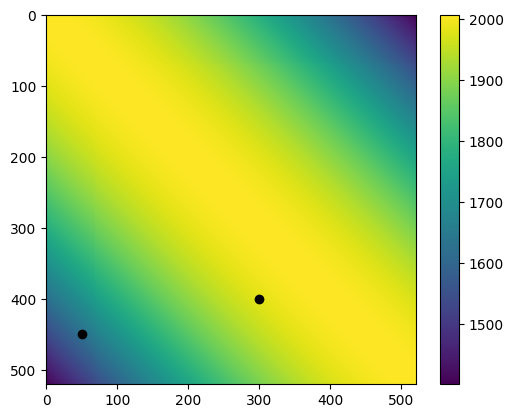

In [18]:
krnl = 44.8**2 * RBF(length_scale=51.6)

opt_kern_matrix=krnl(co2_data[['date']].values)
plt.imshow(opt_kern_matrix, cmap='viridis', origin='upper')
plt.colorbar()

# Highlight 2 points on the contour
point1 = (50, 450)  
point2 = (300, 400) 

# Plot the points
plt.scatter(*point1, color='black', label='Point 1')
plt.scatter(*point2, color='black', label='Point 2')

# Annotate with dashed arrows
#arrow_properties = dict(arrowstyle='->', linestyle='dashed', color='black')
plt.annotate('', point1, point2, ) #arrowprops=arrow_properties
plt.annotate('', point2, point1, ) # arrowprops=arrow_properties

plt.show()

The contour plot above displays the kernel values of the long term rising component. The x- and y-axis are the indexes associated to the input values. Given two data points, the length scale determines the distance where one data point is still expected to influence the other data point. The constant that multiplies the RBF determines the magnitude of this influence (z-axis scale). We can see, for example, the two highlighted black points at (50, 450) and (300, 400). The influence of each data point on the other for the data points at indexes 50 and 450 is less than the influence observed for the data points at indexes 300 and 400. In fact, the influence that each data point has on another data point for a given pair fades with a length scale of ~52.  

The kernel functional describing the irregularities (RationalQuadratic) of the generating process is:

$k(x_i, x_j) = \left(1 + \frac{d(x_i, x_j)^2}{2\alpha l^2}\right)^{-\alpha}$.

This can be interpreted as an infinite sum of RBF kernels having different length scales. The scale mixture parameter $\alpha$ determines the difference in the length scales of the infinitesimal RBF components. 

2023-12-14 18:28:10,204 - POLYGP DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x282749390>


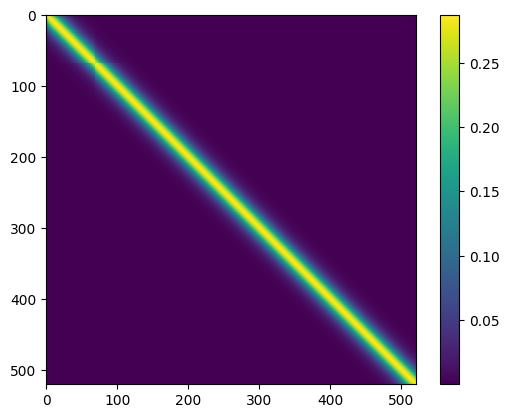

In [19]:
krnl = 0.536**2 * RationalQuadratic(alpha=2.89, length_scale=0.968)

opt_kern_matrix=krnl(co2_data[['date']].values)
plt.imshow(opt_kern_matrix, cmap='viridis', origin='upper')
plt.colorbar()

plt.show()

Changing the length scale here will have the same effect described for the RBF kernel. However, $\alpha$ balances between short and long-term variations in the function. If $\alpha$ is small, the kernel allows for more non-smooth and non-linear behavior. We can observe how the largest kernel values are along the diagonal highlighting how this kernel emphasizes the local irregularities.  
If we assign a much smaller value to $\alpha$, we can see below how these irregularities are allowed to "propagate" further where the distance between points in a pair is larger.

2023-12-14 18:28:10,366 - POLYGP DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x28991eb30>


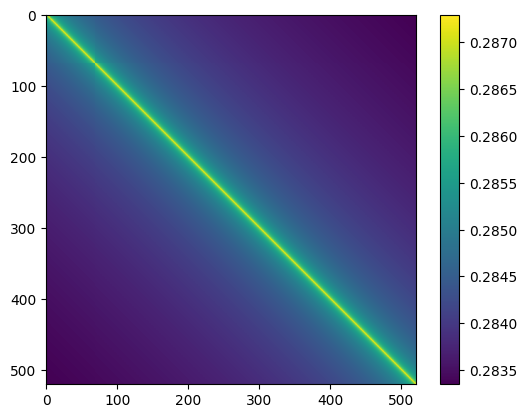

In [20]:
krnl = 0.536**2 * RationalQuadratic(alpha=1e-3, length_scale=0.968)

opt_kern_matrix=krnl(co2_data[['date']].values)

plt.imshow(opt_kern_matrix, cmap='viridis', origin='upper')
#plt.xlim(0, 100)
#plt.ylim(100, 0)
plt.colorbar()

plt.show()

The last kernel we want to discuss here is the ExpSineSquared kernel, whose functional is:

$k(x_i, x_j) = \text{exp}\left(- \frac{ 2\sin^2(\pi d(x_i, x_j) / p) }{ l^ 2} \right)$

The additional parameter $p$ is the periodicity parameter. The periodical component alone for our exercise with the Mauna Loa dataset is shown below.

2023-12-14 18:28:10,511 - POLYGP DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x289a09b40>


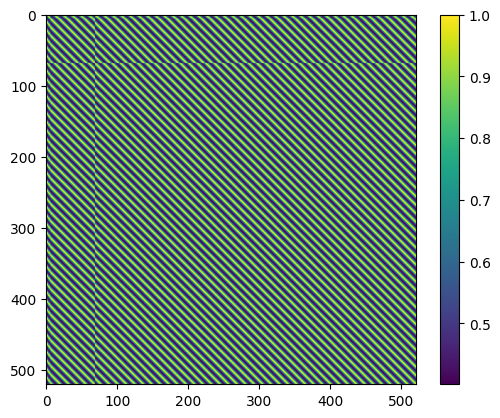

In [21]:
krnl = ExpSineSquared(length_scale=1.48, periodicity=1)

opt_kern_matrix=krnl(co2_data[['date']].values)
plt.imshow(opt_kern_matrix, cmap='viridis', origin='upper')
plt.colorbar()

plt.show()

As we can see, the period of 1 is markedly visible in the contour plot. The length scale determines how many neighboring points influence each other (widths of the periodic bands).

#### Combining Base Kernels

For the Mauna Loa dataset, we used a decay time of ~90 years on top of the periodic component. This was an example of kernel composition. 

2023-12-14 18:28:10,669 - POLYGP DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x289ab7b20>


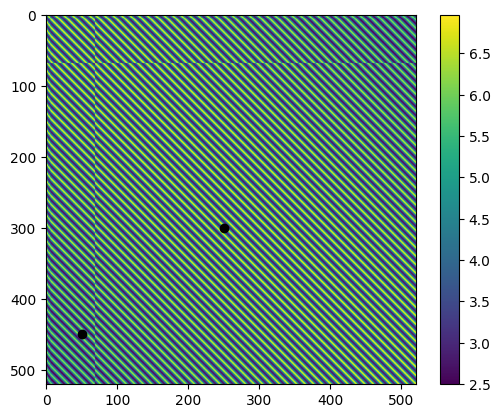

In [22]:
krnl = 2.64**2 * RBF(length_scale=91.5) * ExpSineSquared(length_scale=1.48, periodicity=1)

opt_kern_matrix=krnl(co2_data[['date']].values)
plt.imshow(opt_kern_matrix, cmap='viridis', origin='upper')
plt.colorbar()

# Highlight 2 points on the contour
point1 = (50, 450)  
point2 = (250, 300) 

# Plot the points
plt.scatter(*point1, color='black', label='Point 1')
plt.scatter(*point2, color='black', label='Point 2')

# Annotate with dashed arrows
#arrow_properties = dict(arrowstyle='->', linestyle='dashed', color='black')
plt.annotate('', point1, point2, ) #arrowprops=arrow_properties
plt.annotate('', point2, point1, ) # arrowprops=arrow_properties

plt.show()

As we can see, the pair of points indicated with the black dot at (50, 450) is in a slightly darker area than the black dot for the pair at (250, 300). This indicates that there is less "similarity" between data points with greater distances. The result is a periodic component with a decaying amplitude.

Multiplying kernels is like an AND operation. In fact, two data points are considered similar only if both kernels have high values. Similarly, a sum of kernels can be thought of as an OR operation: two data points are considered similar
if either kernel has a high value. We show a sum of kernels below.

2023-12-14 18:28:10,887 - POLYGP DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x289babb20>


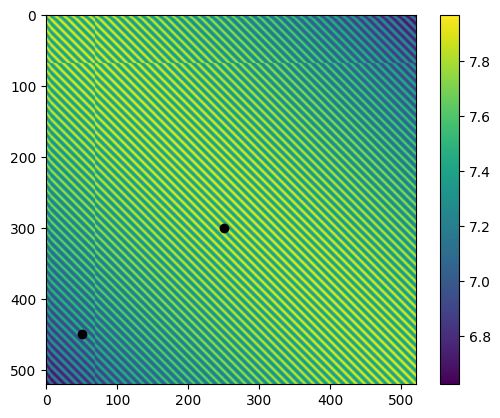

In [23]:
krnl = 2.64**2 * RBF(length_scale=91.5) + ExpSineSquared(length_scale=1.48, periodicity=1)

opt_kern_matrix=krnl(co2_data[['date']].values)
plt.imshow(opt_kern_matrix, cmap='viridis', origin='upper')
plt.colorbar()

# Highlight 2 points on the contour
point1 = (50, 450)  
point2 = (250, 300) 

# Plot the points
plt.scatter(*point1, color='black', label='Point 1')
plt.scatter(*point2, color='black', label='Point 2')

# Annotate with dashed arrows
#arrow_properties = dict(arrowstyle='->', linestyle='dashed', color='black')
plt.annotate('', point1, point2, ) #arrowprops=arrow_properties
plt.annotate('', point2, point1, ) # arrowprops=arrow_properties

plt.show()

#### Finding An Optimal Combination of Kernels

We build an optimized polynomial with its base elements belonging to the list of $M$ kernel functions selected from a list of $N$ available base kernel functions 

$P(\mathbf{x}) = \epsilon (x) + \sum_{K_1, K_2, \ldots , K_M\in\{K_1,\dots, K_N\}} a_{K_1, K_2, \ldots, K_M} K_1(x) K_2(x) \ldots K_M(x)$,

where $a_{K_1, K_2, \ldots, K_M}$ represents the ConstantKernel used as the coefficient of the polynomial term containing $K_1, K_2, \ldots , K_M$ and $E(x)$ represents the noise kernel function.

For example, we can consider the following list of base kernels (available in *scikit-learn*) to compose the kernel polynomial.

In [24]:
base_kernels = [
  'RBF()',
  'DotProduct()',
  'Matern()',
  'RationalQuadratic()',
  'ExpSineSquared()',
]

For simplicity, we show below an example of kernel composition using an initial set of 5 base kernels, labeled A, B, C, D, E. 

We can require our kernel polynomial to have interaction terms such as $A*B$ or $A*B*C$ up to a given degree level. For example, we can enforce to have up to 2-degree interaction terms. In this case, the kernel polynomial will not have terms such as $A*B*C$ but it will have terms such as $A$, $A*B$, etc.

We can also limit the number of polynomial terms. For example, we can allow for polynomials with up to 3 terms. In this case, polynomials such as $A + A*B$ and $A + A*B + A*C$ will be available but polynomials such as $A + A*B + A*C + A*E$ will not be available.

In [25]:
base_kernels = ['A', 'B', 'C', 'D', 'E']

In [26]:
interaction_degree = 2
max_sum_terms = 4
poly_terms = ['k' + '*' + '*'.join(i) for i in list(itertools.chain.from_iterable(itertools.combinations(['A','B','C'], i) for i in range(1, interaction_degree+1)))]
polys = ['e + ' + ' + '.join(i) for i in list(itertools.chain.from_iterable(itertools.combinations(poly_terms, i) for i in range(1, max_sum_terms+1)))]

print(f'{len(polys)} available polynomials such as {polys[-3:]}')

56 available polynomials such as ['e + k*B + k*C + k*A*C + k*B*C', 'e + k*B + k*A*B + k*A*C + k*B*C', 'e + k*C + k*A*B + k*A*C + k*B*C']


We can select the kernel polynomial by index.

In [27]:
base_kernels = ['A', 'B', 'C', 'D', 'E', 'F']

print(f"The selected polynomial is {build_poly_kernel(base_kernels, 2, 4, 'e', 'k()')[50]}")

The selected polynomial is e + k() * B + k() * B * C


In the example above, we let *interc_coeff='k'* be the coefficient for all terms. This will be replaced with a ConstantKernel whose parameter value will be optimized. Also, *interc_coeff* here represents the independednt additional error that can be added to the kernel, typically WhiteNoise() + RBF().

The search for the optimal kernel polynomial is typically a non-convex optimization problem with many local minima/optimal kernels. We will use the Covariance Matrix Adaptation Evolution Strategy (CMA-ES) [algorithm](https://arxiv.org/abs/1604.00772), which is an evolutionary strategy (stochastic, derivative-free) that is available in [Optuna](https://optuna.readthedocs.io/en/stable/index.html) as [optuna.samplers.CmaEsSampler](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.samplers.CmaEsSampler.html). Note that this sampler does not support categorical distributions. For these situations, we would opt for the [TPESampler](https://optuna.readthedocs.io/en/stable/reference/samplers/generated/optuna.samplers.TPESampler.html) (Tree-structured Parzen Estimator). The latter optimization approach is described in details in [Bergstra, James S., et al. “Algorithms for hyper-parameter optimization.” Advances in Neural Information Processing Systems. 2011](https://papers.nips.cc/paper_files/paper/2011/hash/86e8f7ab32cfd12577bc2619bc635690-Abstract.html) and [Bergstra, James, Daniel Yamins, and David Cox. “Making a science of model search: Hyperparameter optimization in hundreds of dimensions for vision architectures.” Proceedings of The 30th International Conference on Machine Learning. 2013](https://proceedings.mlr.press/v28/bergstra13.html).

The search is set to explore 1000 trials with an early stopping if no improvement is found in 200 trials. The objective function builds and trains a modeling pipeline that preprocesses the data (scaling) and fits a Gaussian process regression model using the kernel of the trial. For smaller datasets (50 or fewer data rows), minimizing the Bayesian Information Criterion (BIC) drives the search for the optimal polynomial kernel. BIC is defined as

$BIC = k\log(n) - 2\log(\hat{L})$

where $\hat{L}$ is the estimated log-likelihood of the Gaussian process regression model, $n$ is the number of data rows, $k$ is the number of parameters of the kernel function. The hyperparameter values of the kernel are optimized when fitting the Gaussian process regressor by maximizing the log-marginal-likelihood (LML) as described [here](https://scikit-learn.org/stable/modules/gaussian_process.html).

For larger datasets, adopting the approach described above would lead to impracticable computational times. Therefore, we stratify the dataset based on the target variable using [KBinsDiscretizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html). The target values are binned so that all bins have the same number of data (quantile strategy). The stratification happens by utilizing the bin IDs. At each trial, 50 data rows are sampled using this stratification of the target and are used to train the Gaussian process regressor while optimizing its kernel hyperparameter values. Different data samples are utilized at each trial. In the case of a kernel already tried previously in the search, the kernel is initialized with the hyperparameter values found earlier. The whole dataset is then used to only fit the model without further optimizing its kernel hyperparameter values. The search of the optimal polynomial kernel is driven by minimizing BIC calculated using the LML from this fit. A fundamental challenge with Gaussian processes is [scalability](https://arxiv.org/abs/1903.08114). The covariance matrix inversion complexity increases quadratically with the size of the data. 

To test this approach, we let Optuna find an optimal polynomial with no more than 2 base kernels in product terms and no more than 3 total terms plus the additional noise term. This will allows us to see how the result compares to the kernel used in the study described in the previous section.

Running multiple times may result into slightly different kernel polynomials since this optimization problem is not convex. In fact, we should always look at the top trials to make a decision on the kernel to adopt based on our intuition of the problem.

In [28]:
co2_mean = co2_data['co2'].mean()
co2_data['co2_shifted'] = co2_data['co2'] - co2_mean

In [ ]:
base_kernels = [
        'RBF()',
        'RationalQuadratic()',
        'ExpSineSquared()',
]

gaussian_process_opt, llh_opt, kernel_opt, study_opt = train_gp(co2_data, ['date'], ['co2_shifted'],
                                                                [], ['date'],
                                                                max_evals=1000, early_stopping_rounds=200, 
                                                                base_kernels=base_kernels,
                                                                model_complexity = {'max_n_prod': 2, 
                                                                                    'max_n_sum': 3, 
                                                                                    'comb_type': 'worepl'},
                                                                )
# remove output before converting to html

The kernel with the lowest BIC value is the following:

In [53]:
str(kernel_opt).split(' + ') 

['0.00536**2 * RBF(length_scale=0.0014)',
 'WhiteKernel(noise_level=8.77e-05)',
 '0.0264**2 * RationalQuadratic(alpha=324, length_scale=2.61)',
 '0.618**2 * RBF(length_scale=0.101) * RationalQuadratic(alpha=0.0152, length_scale=0.000146)',
 '37.5**2 * RBF(length_scale=4.23) * ExpSineSquared(length_scale=7.14, periodicity=0.0798)']

We can also look at other optimal kernels sorted by increasing $BIC$ values

In [54]:
import optuna

all_trials = study_opt.get_trials(states=[optuna.trial.TrialState.COMPLETE])
## sort trials by their values in ascending order if minimizing
sorted_trials = sorted(all_trials, key=lambda t: t.value, reverse=False) 
## remove trials without kernel info
sorted_trials = [i for i in sorted_trials if i.user_attrs]
## identify duplicates and remove
sorted_trials_lst = [(str(i.user_attrs['extra_info']['krnl']), np.round(i.value, 3)) for i in sorted_trials]
sorted_trials_lst[:5]

[('0.00536**2 * RBF(length_scale=0.0014) + WhiteKernel(noise_level=8.77e-05) + 0.0264**2 * RationalQuadratic(alpha=324, length_scale=2.61) + 0.618**2 * RBF(length_scale=0.101) * RationalQuadratic(alpha=0.0152, length_scale=0.000146) + 37.5**2 * RBF(length_scale=4.23) * ExpSineSquared(length_scale=7.14, periodicity=0.0798)',
  445.902),
 ('0.00536**2 * RBF(length_scale=0.0014) + WhiteKernel(noise_level=8.78e-05) + 0.0264**2 * RationalQuadratic(alpha=324, length_scale=2.61) + 0.635**2 * RBF(length_scale=0.0655) * RationalQuadratic(alpha=0.0276, length_scale=0.000131) + 37**2 * RBF(length_scale=4.17) * ExpSineSquared(length_scale=7.48, periodicity=0.0791)',
  533.741),
 ('0.0201**2 * RBF(length_scale=3.72e-05) + WhiteKernel(noise_level=0.000316) + 0.489**2 * RBF(length_scale=0.000119) + 13.8**2 * RBF(length_scale=0.486) * ExpSineSquared(length_scale=5.83, periodicity=0.079)',
  883.828),
 ('0.0481**2 * RBF(length_scale=0.035) + WhiteKernel(noise_level=0.1) + 0.597**2 * RBF(length_scale=0.

Finally, we can show the different components of the optimized kernel to identify their "signatures". As we can see below the dominant component is 

37.5**2 * RBF(length_scale=4.23) * ExpSineSquared(length_scale=7.14, periodicity=0.0798)

2023-12-15 09:17:16,566 - POLYGP DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x28e88e0e0>


Optimized kernel: 0.00536**2 * RBF(length_scale=0.0014) + WhiteKernel(noise_level=8.77e-05) + 0.0264**2 * RationalQuadratic(alpha=324, length_scale=2.61) + 0.618**2 * RBF(length_scale=0.101) * RationalQuadratic(alpha=0.0152, length_scale=0.000146) + 37.5**2 * RBF(length_scale=4.23) * ExpSineSquared(length_scale=7.14, periodicity=0.0798)


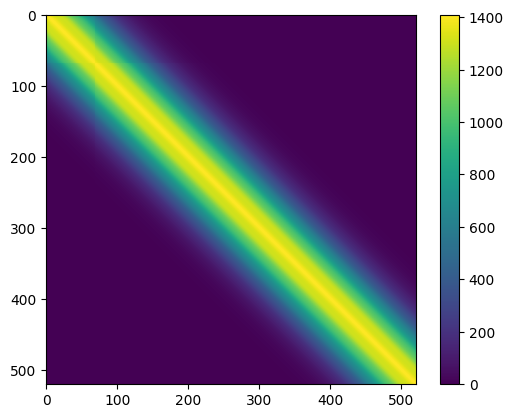

2023-12-15 09:17:16,668 - POLYGP DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x28dcef940>


0.00536**2 * RBF(length_scale=0.0014)


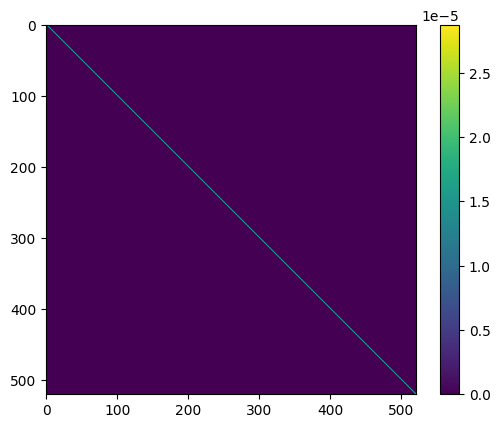

WhiteKernel(noise_level=8.77e-05)


2023-12-15 09:17:16,763 - POLYGP DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x28d9ad2d0>


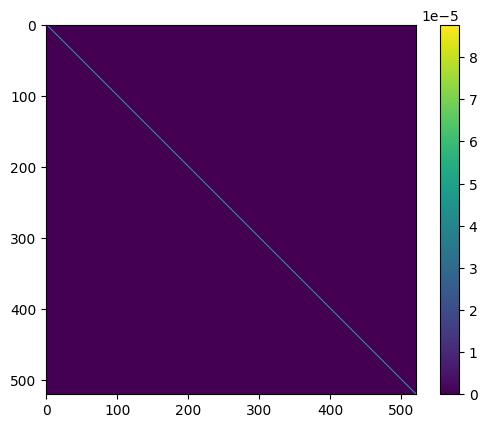

2023-12-15 09:17:16,895 - POLYGP DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x28e9abc70>


0.0264**2 * RationalQuadratic(alpha=324, length_scale=2.61)


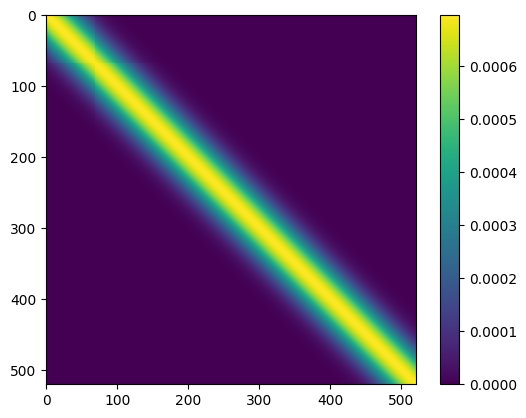

2023-12-15 09:17:17,002 - POLYGP DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x28e9a9ff0>


0.618**2 * RBF(length_scale=0.101) * RationalQuadratic(alpha=0.0152, length_scale=0.000146)


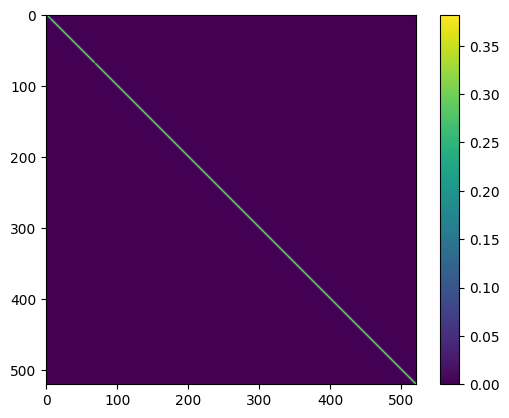

2023-12-15 09:17:17,100 - POLYGP DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x28e8ec3d0>


37.5**2 * RBF(length_scale=4.23) * ExpSineSquared(length_scale=7.14, periodicity=0.0798)


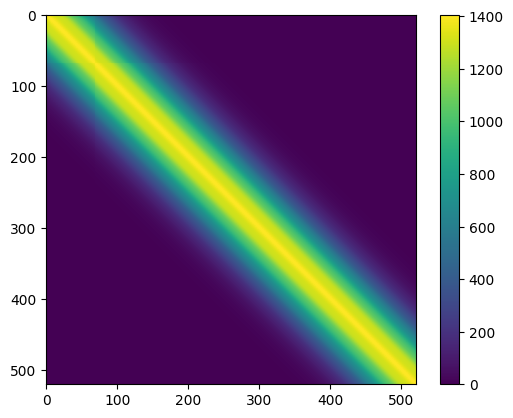

In [55]:
from contextlib import redirect_stdout
from io import StringIO

opt_kern_matrix=kernel_opt(co2_data[['date']].values)
print('Optimized kernel:', kernel_opt)
plt.imshow(opt_kern_matrix, cmap='viridis', origin='upper')
plt.colorbar()
plt.show()

for krnl in str(kernel_opt).split(' + '): 

    print(krnl)

    output_catcher = StringIO()
    exec_scope = {}
    code_to_exec = f'''from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, DotProduct, Matern, RationalQuadratic, ExpSineSquared
krnl = {krnl}
    '''
    try:
        with redirect_stdout(output_catcher):
            exec(code_to_exec, exec_scope)
    except Exception as e:
        print(f"An error occurred: {e}")
    krnl = exec_scope['krnl']
    opt_kern_matrix=krnl(co2_data[['date']].values)
    plt.imshow(opt_kern_matrix, cmap='viridis', origin='upper')
    plt.colorbar()
    plt.show()

As before, we can show the fit and the forecast lines.

In [56]:
mean_prediction, std_prediction = gaussian_process_opt.predict(co2_data[['date']], return_std=True)
mean_prediction = mean_prediction.reshape(-1,1) + co2_mean
std_prediction = std_prediction.reshape(-1,1)
mse_all = mean_squared_error(co2_data['co2'], mean_prediction)
r2_all = r2_score(co2_data['co2'], mean_prediction)
        
polygp_plot = create_regression_plot(plot_title='Monthly average of measurements from Mauna Loa Observatory',
                                   text_display=f"llh: {np.round(llh_opt,3)}<br>mse: {np.round(mse_all,3)}<br>r2: {np.round(r2_all,3)}",
                                   dic_traces={'hist': {'X': co2_data[['date']].values, 
                                                'Z': co2_data[['co2']].values, 
                                                'dX': None, 'dZ': None, 
                                                'label': 'CO2 - Historical', 
                                                'xlabel': 'date',
                                                'ylabel': 'CO2',
                                                'modes':'lines', 
                                                'errors': 'confidence+bars',
                                                'line_dict': dict(dash='dash', color='rgba(0, 0, 255, 1)'), 'ix': 0, 'iz': 0},
                                               'fit': {'X': co2_data[['date']].values, 
                                                'Z': mean_prediction, 
                                                'dX': None, 'dZ': std_prediction, 
                                                'label': 'CO2 - GPR', 
                                                'xlabel': 'date',
                                                'ylabel': 'CO2',
                                                'modes':'lines', 
                                                'errors': 'confidence',
                                                'line_dict': dict(color='rgba(0, 128, 0, 1)'), 'ix': 0, 'iz': 0}})


In [59]:

polygp_plot


In [57]:
today = datetime.datetime.now()
current_month = today.year + today.month / 12
co2_data_test = pd.DataFrame({'date': np.linspace(start=1958, stop=current_month, num=1_000)})
co2_data_test = pd.concat([co2_data, co2_data_test], axis=0).reset_index(drop=True)

mean_prediction, std_prediction = gaussian_process_opt.predict(co2_data_test[['date']], return_std=True)
mean_prediction = mean_prediction.reshape(-1,1) + co2_mean
std_prediction = std_prediction.reshape(-1,1)

polygp_forecast_plot = create_regression_plot(plot_title='Monthly average of measurements from Mauna Loa Observatory',
                                   text_display="",
                                   dic_traces={'hist': {'X': co2_data_test[['date']].values, 
                                                'Z': co2_data_test[['co2']].values, 
                                                'dX': None, 'dZ': None, 
                                                'label': 'CO2 - Historical', 
                                                'xlabel': 'date',
                                                'ylabel': 'CO2',
                                                'modes':'lines', 
                                                'errors': 'confidence+bars',
                                                'line_dict': dict(dash='dash', color='rgba(0, 0, 255, 1)'), 'ix': 0, 'iz': 0},
                                               'fit': {'X': co2_data_test[['date']].values, 
                                                'Z': mean_prediction, 
                                                'dX': None, 'dZ': std_prediction, 
                                                'label': 'CO2 - GPR', 
                                                'xlabel': 'date',
                                                'ylabel': 'CO2',
                                                'modes':'lines', 
                                                'errors': 'confidence',
                                                'line_dict': dict(color='rgba(0, 128, 0, 1)'), 'ix': 0, 'iz': 0}})


In [60]:
polygp_forecast_plot

In [ ]:
#jupyter nbconvert --to html --TagRemovePreprocessor.remove_input_tags="notvisible" mauna_gpr.ipynb --output 01_01_2024_polygp_sklearn.html


Copyright (c) [2023] [Alessio Tamburro]

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.


[MIT license](https://choosealicense.com/licenses/mit/)